In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [64]:
df = pd.read_csv('/content/Dataset-05.csv')

<ipython-input-64-a9101a195248>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Dataset-05.csv')


In [65]:
df.head()

,evid,ev_lat,ev_lon,ev_depth,mag,tect_class,sta,lat,lon,Vs30,...,f28.41901982,f30.2601738,f32.22060875,f34.3080524,f36.53073312,f38.89741238,f41.41741928,f44.10068729,f46.95779344,f50
0,1476956,-45.08298,167.45192,5.0000,3.999576,Crustal,MSZS,-43.532099,169.815480,1000,...,0.000884,0.000794,0.000749,0.000673,0.000474,0.000285,0.000187,0.000148,0.000117,0.000080
1,1485433,-44.46069,168.06258,5.0000,4.424900,Crustal,MSZS,-43.532099,169.815480,1000,...,0.003845,0.003571,0.003185,0.002254,0.001599,0.001198,0.000886,0.000655,0.000472,0.000329
2,1502697,-41.01747,175.44363,29.0304,4.099265,Slab,MAVS,-42.425812,173.682125,800,...,0.000174,0.000158,0.000150,0.000105,0.000096,0.000092,0.000077,0.000072,0.000068,0.000058
3,1502698,-41.06073,175.43401,30.7174,5.200000,Slab,MAVS,-42.425812,173.682125,800,...,0.001355,0.000980,0.000744,0.000538,0.000662,0.000626,0.000469,0.000406,0.000337,0.000326
4,1502698,-41.06073,175.43401,30.7174,5.200000,Slab,MISS,-39.294200,174.014500,636,...,0.000924,0.000667,0.000405,0.000393,0.000358,0.000306,0.000253,0.000194,0.000186,0.000166


In [66]:
df = df.loc[~(df == 0).any(axis=1)]
len(df)

46426

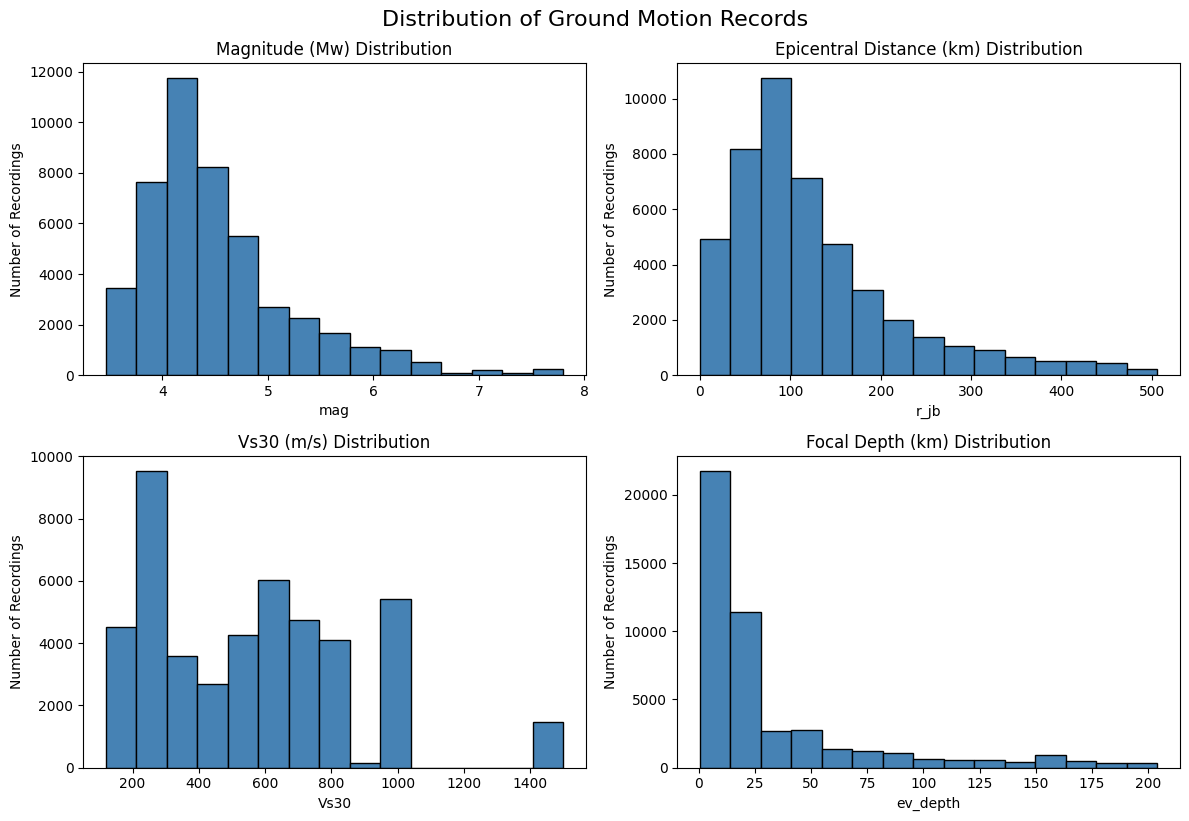

In [67]:
columns = {
    'mag': 'Magnitude (Mw)',
    'r_jb': 'Epicentral Distance (km)',
    'Vs30': 'Vs30 (m/s)',
    'ev_depth': 'Focal Depth (km)'
}

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax, (col, label) in zip(axs.flat, columns.items()):
    ax.hist(df[col].dropna(), bins=15, edgecolor='black', color='steelblue')
    ax.set_title(f'{label} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Number of Recordings')

plt.tight_layout()
plt.suptitle('Distribution of Ground Motion Records', fontsize=16, y=1.02)
plt.show()

input_params = ["mag", "Vs30", "r_jb", "ev_depth"]


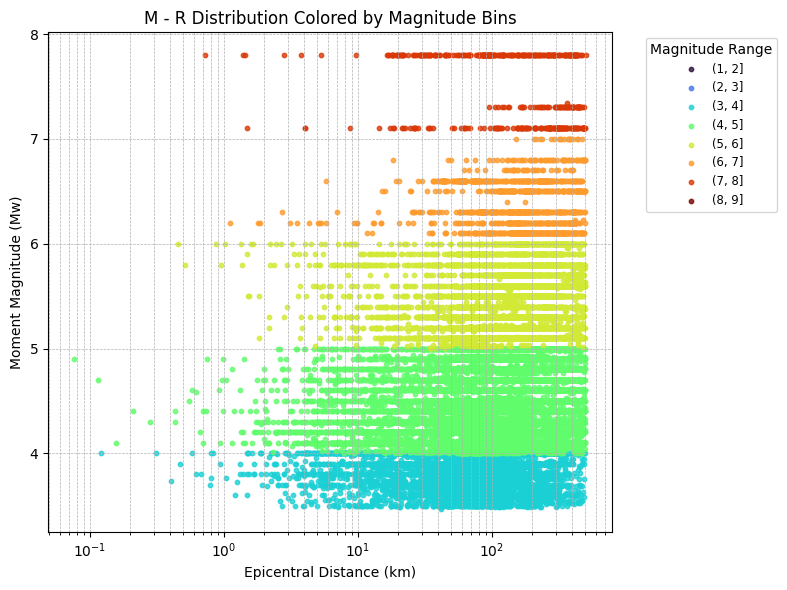

In [68]:
bins = np.arange(1, 10, 1)
df['mag_bin'] = pd.cut(df['mag'], bins)

bin_labels = df['mag_bin'].cat.categories
colors = plt.cm.turbo(np.linspace(0, 1, len(bin_labels)))
color_map = dict(zip(bin_labels, colors))

plt.figure(figsize=(8, 6))

for bin_label in bin_labels:
    bin_data = df[df['mag_bin'] == bin_label]
    plt.scatter(
        bin_data['r_jb'],
        bin_data['mag'],
        s=10,
        alpha=0.8,
        label=str(bin_label),
        color=color_map[bin_label]
    )

plt.xscale('log')
plt.xlabel('Epicentral Distance (km)')
plt.ylabel('Moment Magnitude (Mw)')
plt.title('M - R Distribution Colored by Magnitude Bins')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Legend outside
plt.legend(title='Magnitude Range', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

Parameters to consider:

X -> r_jb, log(r_jb), mag, ev_depth, log(Vs30)

y -> 100 target values

In [69]:
X = []
y = []

for i in range(len(df)):
  row = df.iloc[i].tolist()

  try:
    X_temp = [float(row[3]), float(row[10]), math.log(float(row[10])), math.log(float(row[9])), float(row[4])]
  except ValueError:
    continue
  X.append(X_temp)

  y_temp = []
  for j in range(100):
    y_temp.append(float(row[j+12]))
  y.append(y_temp)

In [70]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((46426, 5), (46426, 100))

In [71]:
print("y min:", np.min(y))
print("y max:", np.max(y))
print("y mean:", np.mean(y))
print("y std:", np.std(y))

y min: 6.25e-08
y max: 4.758343822
y mean: 0.0059693905770543424
y std: 0.04201220628553827


y values are very sparse, therefore we can remove 99th percentile and 1st percentile data through a filter

In [72]:
y_whole = []
for i in range(len(y)):
  for j in range(56):
    y_whole.append(y[i][j])

y_high = np.percentile(y_whole, 98)
y_low = np.percentile(y_whole, 2)

y_high, y_low

(np.float64(0.06670811459999987), np.float64(7.12e-06))

In [29]:
for i in range(len(y)):
  for j in range(56):
    if y[i][j] >= y_high:
      y[i][j] = y_high

for i in range(len(y)):
  for j in range(56):
    if y[i][j] <= y_low:
      y[i][j] = y_low

# Preprocessing Data

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
y_log = np.log(y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (37141, 5) (37141, 100)
Test set shape: (9286, 5) (9286, 100)


# Model - BNN

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

In [42]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=256),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=256, out_features=128),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=128, out_features=64),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=100),
)

In [45]:
batch_size=16
lr=3e-4
n_epochs=25

input_data_tensor = torch.tensor(X_train, dtype=torch.float32)
target_data_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(input_data_tensor,target_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


optimizer = optim.Adam(model.parameters(), lr=lr)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1
mse_loss = nn.MSELoss(reduction='mean')
mae_loss=nn.L1Loss(reduction='mean')

model.train()

for epoch in range(n_epochs):
    total_loss = 0
    for features,target in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        target_pred=model(features)
        loss=mse_loss(target,target_pred)+mae_loss(target,target_pred)+kl_weight*kl_loss(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:}")

Epoch 1/25: 100%|██████████| 1161/1161 [00:12<00:00, 95.59it/s] 


Epoch 1, Average Loss: 2.1800794260549092


Epoch 2/25: 100%|██████████| 1161/1161 [00:11<00:00, 99.02it/s] 


Epoch 2, Average Loss: 2.1678306523527593


Epoch 3/25: 100%|██████████| 1161/1161 [00:11<00:00, 101.98it/s]


Epoch 3, Average Loss: 2.1611461521324467


Epoch 4/25: 100%|██████████| 1161/1161 [00:11<00:00, 100.69it/s]


Epoch 4, Average Loss: 2.151442612172405


Epoch 5/25: 100%|██████████| 1161/1161 [00:11<00:00, 98.33it/s]


Epoch 5, Average Loss: 2.1470642241807356


Epoch 6/25: 100%|██████████| 1161/1161 [00:11<00:00, 104.60it/s]


Epoch 6, Average Loss: 2.1412483651919367


Epoch 7/25: 100%|██████████| 1161/1161 [00:11<00:00, 102.36it/s]


Epoch 7, Average Loss: 2.137238907875633


Epoch 8/25: 100%|██████████| 1161/1161 [00:12<00:00, 96.21it/s]


Epoch 8, Average Loss: 2.1337351056648473


Epoch 9/25: 100%|██████████| 1161/1161 [00:11<00:00, 96.91it/s] 


Epoch 9, Average Loss: 2.1284529876339344


Epoch 10/25: 100%|██████████| 1161/1161 [00:11<00:00, 102.45it/s]


Epoch 10, Average Loss: 2.1285228345231904


Epoch 11/25: 100%|██████████| 1161/1161 [00:11<00:00, 99.52it/s] 


Epoch 11, Average Loss: 2.119883250615188


Epoch 12/25: 100%|██████████| 1161/1161 [00:11<00:00, 99.81it/s] 


Epoch 12, Average Loss: 2.1135881433807295


Epoch 13/25: 100%|██████████| 1161/1161 [00:11<00:00, 98.39it/s] 


Epoch 13, Average Loss: 2.1116506304851796


Epoch 14/25: 100%|██████████| 1161/1161 [00:11<00:00, 100.21it/s]


Epoch 14, Average Loss: 2.1103512750012827


Epoch 15/25: 100%|██████████| 1161/1161 [00:13<00:00, 89.21it/s] 


Epoch 15, Average Loss: 2.1076475870599016


Epoch 16/25: 100%|██████████| 1161/1161 [00:12<00:00, 95.58it/s] 


Epoch 16, Average Loss: 2.102147099789004


Epoch 17/25: 100%|██████████| 1161/1161 [00:10<00:00, 111.34it/s]


Epoch 17, Average Loss: 2.1016358931859336


Epoch 18/25: 100%|██████████| 1161/1161 [00:11<00:00, 103.00it/s]


Epoch 18, Average Loss: 2.1009866682031255


Epoch 19/25: 100%|██████████| 1161/1161 [00:11<00:00, 102.68it/s]


Epoch 19, Average Loss: 2.09221705981722


Epoch 20/25: 100%|██████████| 1161/1161 [00:11<00:00, 100.58it/s]


Epoch 20, Average Loss: 2.086846602158132


Epoch 21/25: 100%|██████████| 1161/1161 [00:11<00:00, 101.77it/s]


Epoch 21, Average Loss: 2.091362168417215


Epoch 22/25: 100%|██████████| 1161/1161 [00:11<00:00, 102.65it/s]


Epoch 22, Average Loss: 2.085103209320581


Epoch 23/25: 100%|██████████| 1161/1161 [00:11<00:00, 104.69it/s]


Epoch 23, Average Loss: 2.0844902934748792


Epoch 24/25: 100%|██████████| 1161/1161 [00:11<00:00, 103.22it/s]


Epoch 24, Average Loss: 2.081441875576049


Epoch 25/25: 100%|██████████| 1161/1161 [00:11<00:00, 104.48it/s]

Epoch 25, Average Loss: 2.0805013550447042


In [92]:
history = '''Epoch 1/25: 100%|██████████| 2322/2322 [00:17<00:00, 130.67it/s]
Epoch 1, Average Loss: 6.674455850109984
Epoch 2/25: 100%|██████████| 2322/2322 [00:17<00:00, 130.23it/s]
Epoch 2, Average Loss: 3.1203784479035273
Epoch 3/25: 100%|██████████| 2322/2322 [00:17<00:00, 135.94it/s]
Epoch 3, Average Loss: 2.700498468448744
Epoch 4/25: 100%|██████████| 2322/2322 [00:18<00:00, 122.98it/s]
Epoch 4, Average Loss: 2.5188605286354244
Epoch 5/25: 100%|██████████| 2322/2322 [00:18<00:00, 124.29it/s]
Epoch 5, Average Loss: 2.41948614990167
Epoch 6/25: 100%|██████████| 2322/2322 [00:18<00:00, 128.53it/s]
Epoch 6, Average Loss: 2.355090216046053
Epoch 7/25: 100%|██████████| 2322/2322 [00:17<00:00, 129.46it/s]
Epoch 7, Average Loss: 2.303067037044775
Epoch 8/25: 100%|██████████| 2322/2322 [00:18<00:00, 122.73it/s]
Epoch 8, Average Loss: 2.269592527065885
Epoch 9/25: 100%|██████████| 2322/2322 [00:18<00:00, 126.52it/s]
Epoch 9, Average Loss: 2.2365495571794436
Epoch 10/25: 100%|██████████| 2322/2322 [00:17<00:00, 133.15it/s]
Epoch 10, Average Loss: 2.216454297124467
Epoch 11/25: 100%|██████████| 2322/2322 [00:17<00:00, 131.50it/s]
Epoch 11, Average Loss: 2.195569891184183
Epoch 12/25: 100%|██████████| 2322/2322 [00:17<00:00, 132.90it/s]
Epoch 12, Average Loss: 2.182368714628704
Epoch 13/25: 100%|██████████| 2322/2322 [00:19<00:00, 119.05it/s]
Epoch 13, Average Loss: 2.1695971208127998
Epoch 14/25: 100%|██████████| 2322/2322 [00:18<00:00, 126.21it/s]
Epoch 14, Average Loss: 2.159951743229415
Epoch 15/25: 100%|██████████| 2322/2322 [00:17<00:00, 131.00it/s]
Epoch 15, Average Loss: 2.148615133752092
Epoch 16/25: 100%|██████████| 2322/2322 [00:18<00:00, 125.39it/s]
Epoch 16, Average Loss: 2.140856942773173
Epoch 17/25: 100%|██████████| 2322/2322 [00:17<00:00, 132.68it/s]
Epoch 17, Average Loss: 2.131653156699444
Epoch 18/25: 100%|██████████| 2322/2322 [00:18<00:00, 125.50it/s]
Epoch 18, Average Loss: 2.125926246784762
Epoch 19/25: 100%|██████████| 2322/2322 [00:19<00:00, 119.42it/s]
Epoch 19, Average Loss: 2.120847413603547
Epoch 20/25: 100%|██████████| 2322/2322 [00:17<00:00, 129.70it/s]
Epoch 20, Average Loss: 2.117183991232173
Epoch 21/25: 100%|██████████| 2322/2322 [00:18<00:00, 126.44it/s]
Epoch 21, Average Loss: 2.109062533970027
Epoch 22/25: 100%|██████████| 2322/2322 [00:18<00:00, 124.91it/s]
Epoch 22, Average Loss: 2.106228962527792
Epoch 23/25: 100%|██████████| 2322/2322 [00:19<00:00, 122.00it/s]
Epoch 23, Average Loss: 2.1011555382242295
Epoch 24/25: 100%|██████████| 2322/2322 [00:17<00:00, 132.21it/s]
Epoch 24, Average Loss: 2.0977774727560137
Epoch 25/25: 100%|██████████| 2322/2322 [00:17<00:00, 132.13it/s]
Epoch 25, Average Loss: 2.0943753085805876'''

loss = dict()
for line in history.split("\n")[1::2]:
  loss[int(line.split(" ")[1][:-1])] = float(line.split(" ")[-1])


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

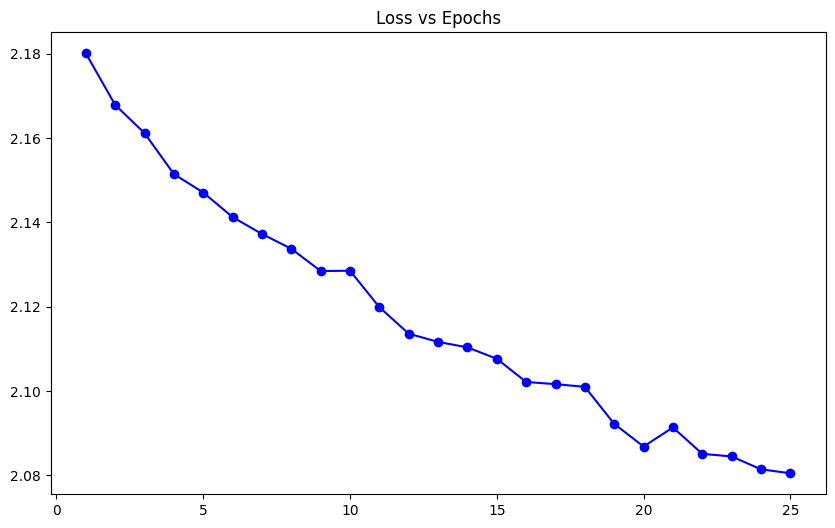

In [84]:
# Plotting loss vs epochs

plt.figure(figsize=(10, 6))
plt.plot(list(loss.keys()), list(loss.values()), marker='o', linestyle='-', color='b')
plt.title('Loss vs Epochs')
plt

We can see that we need to increase the number of epochs

# Regression Plot

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


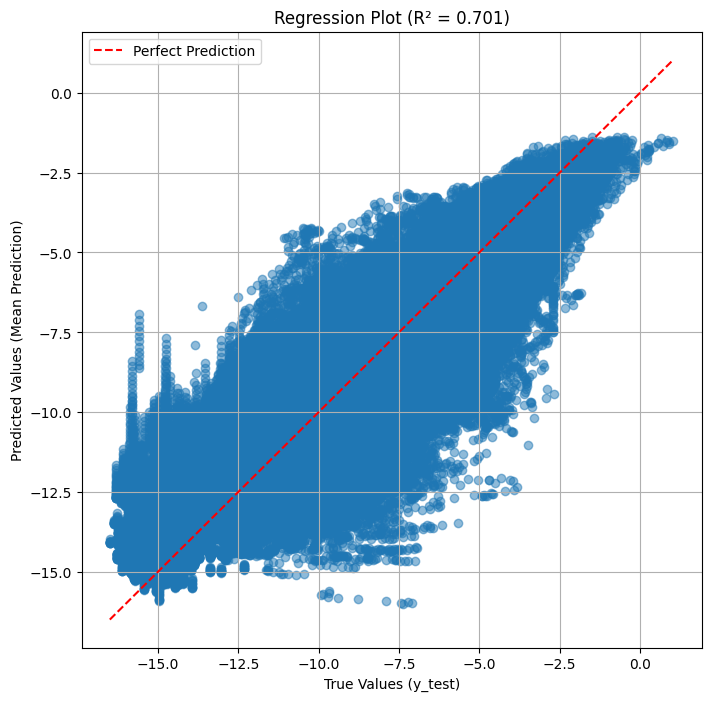

In [60]:
from sklearn.metrics import r2_score

# Mean predictions
mean_preds = mean_prediction.numpy()

# Compute R^2 (coefficient of determination) for performance evaluation
r2 = r2_score(y_test, mean_preds)

# Create the regression plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_tensor.numpy(), mean_preds, alpha=0.5)
plt.plot([y_test_tensor.min(), y_test_tensor.max()],
         [y_test_tensor.min(), y_test_tensor.max()], 'r--', label="Perfect Prediction")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (Mean Prediction)")
plt.title(f"Regression Plot (R² = {r2:.3f})")
plt.grid(True)
plt.legend()
plt.show()

# Residuals

<ipython-input-62-e79f360da747>:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals = mean_prediction - y_test_tensor.numpy()


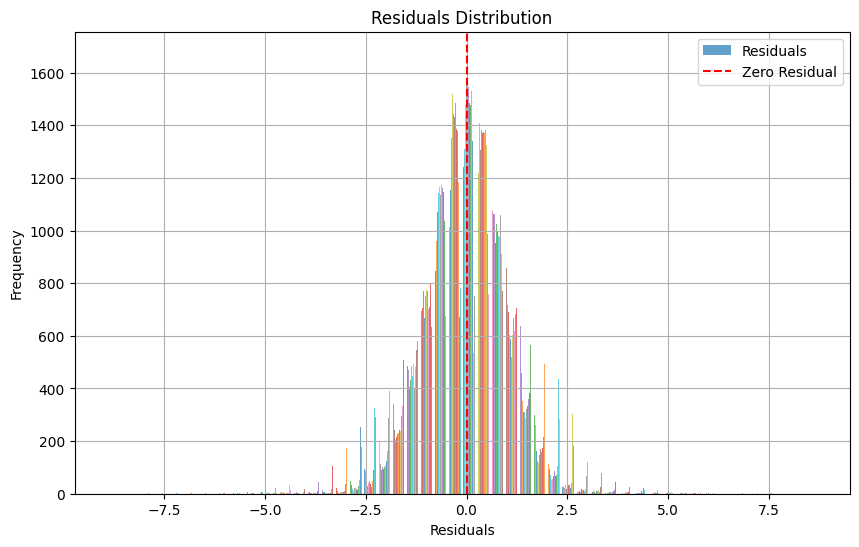

In [62]:
residuals = mean_prediction - y_test_tensor.numpy()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7, label='Residuals')
plt.axvline(0, color='r', linestyle='--', label='Zero Residual')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
df_test = pd.DataFrame({
    'true_values': y_test_tensor.numpy(),
    'predictions': mean_prediction.numpy(),
    'event_id': df["evid"].to_numpy
})

# Calculate residuals for each event
df_test['residuals'] = df_test['predictions'] - df_test['true_values']

# Group by event and calculate intra-event residuals (mean residual for each event)
intra_event_residuals = df_test.groupby('event_id')['residuals'].mean()

# Plot intra-event residuals
plt.figure(figsize=(10, 6))
plt.hist(intra_event_residuals, bins=30, alpha=0.7, color='g', label='Intra-event Residuals')
plt.axvline(0, color='r', linestyle='--', label='Zero Residual')
plt.xlabel('Intra-event Residuals')
plt.ylabel('Frequency')
plt.title('Intra-event Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

# For new model

In [88]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=30),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=30, out_features=50),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=70),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=70, out_features=100),
)

In [89]:
batch_size=16
lr=0.001
n_epochs=25

input_data_tensor = torch.tensor(X_train, dtype=torch.float32)
target_data_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(input_data_tensor,target_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


optimizer = optim.Adam(model.parameters(), lr=lr)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1
mse_loss = nn.MSELoss(reduction='mean')
mae_loss=nn.L1Loss(reduction='mean')

model.train()

for epoch in range(n_epochs):
    total_loss = 0
    for features,target in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        target_pred=model(features)
        loss=mse_loss(target,target_pred)+mae_loss(target,target_pred)+kl_weight*kl_loss(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:}")

Epoch 1/25: 100%|██████████| 2322/2322 [00:17<00:00, 130.67it/s]


Epoch 1, Average Loss: 6.674455850109984


Epoch 2/25: 100%|██████████| 2322/2322 [00:17<00:00, 130.23it/s]


Epoch 2, Average Loss: 3.1203784479035273


Epoch 3/25: 100%|██████████| 2322/2322 [00:17<00:00, 135.94it/s]


Epoch 3, Average Loss: 2.700498468448744


Epoch 4/25: 100%|██████████| 2322/2322 [00:18<00:00, 122.98it/s]


Epoch 4, Average Loss: 2.5188605286354244


Epoch 5/25: 100%|██████████| 2322/2322 [00:18<00:00, 124.29it/s]


Epoch 5, Average Loss: 2.41948614990167


Epoch 6/25: 100%|██████████| 2322/2322 [00:18<00:00, 128.53it/s]


Epoch 6, Average Loss: 2.355090216046053


Epoch 7/25: 100%|██████████| 2322/2322 [00:17<00:00, 129.46it/s]


Epoch 7, Average Loss: 2.303067037044775


Epoch 8/25: 100%|██████████| 2322/2322 [00:18<00:00, 122.73it/s]


Epoch 8, Average Loss: 2.269592527065885


Epoch 9/25: 100%|██████████| 2322/2322 [00:18<00:00, 126.52it/s]


Epoch 9, Average Loss: 2.2365495571794436


Epoch 10/25: 100%|██████████| 2322/2322 [00:17<00:00, 133.15it/s]


Epoch 10, Average Loss: 2.216454297124467


Epoch 11/25: 100%|██████████| 2322/2322 [00:17<00:00, 131.50it/s]


Epoch 11, Average Loss: 2.195569891184183


Epoch 12/25: 100%|██████████| 2322/2322 [00:17<00:00, 132.90it/s]


Epoch 12, Average Loss: 2.182368714628704


Epoch 13/25: 100%|██████████| 2322/2322 [00:19<00:00, 119.05it/s]


Epoch 13, Average Loss: 2.1695971208127998


Epoch 14/25: 100%|██████████| 2322/2322 [00:18<00:00, 126.21it/s]


Epoch 14, Average Loss: 2.159951743229415


Epoch 15/25: 100%|██████████| 2322/2322 [00:17<00:00, 131.00it/s]


Epoch 15, Average Loss: 2.148615133752092


Epoch 16/25: 100%|██████████| 2322/2322 [00:18<00:00, 125.39it/s]


Epoch 16, Average Loss: 2.140856942773173


Epoch 17/25: 100%|██████████| 2322/2322 [00:17<00:00, 132.68it/s]


Epoch 17, Average Loss: 2.131653156699444


Epoch 18/25: 100%|██████████| 2322/2322 [00:18<00:00, 125.50it/s]


Epoch 18, Average Loss: 2.125926246784762


Epoch 19/25: 100%|██████████| 2322/2322 [00:19<00:00, 119.42it/s]


Epoch 19, Average Loss: 2.120847413603547


Epoch 20/25: 100%|██████████| 2322/2322 [00:17<00:00, 129.70it/s]


Epoch 20, Average Loss: 2.117183991232173


Epoch 21/25: 100%|██████████| 2322/2322 [00:18<00:00, 126.44it/s]


Epoch 21, Average Loss: 2.109062533970027


Epoch 22/25: 100%|██████████| 2322/2322 [00:18<00:00, 124.91it/s]


Epoch 22, Average Loss: 2.106228962527792


Epoch 23/25: 100%|██████████| 2322/2322 [00:19<00:00, 122.00it/s]


Epoch 23, Average Loss: 2.1011555382242295


Epoch 24/25: 100%|██████████| 2322/2322 [00:17<00:00, 132.21it/s]


Epoch 24, Average Loss: 2.0977774727560137


Epoch 25/25: 100%|██████████| 2322/2322 [00:17<00:00, 132.13it/s]

Epoch 25, Average Loss: 2.0943753085805876


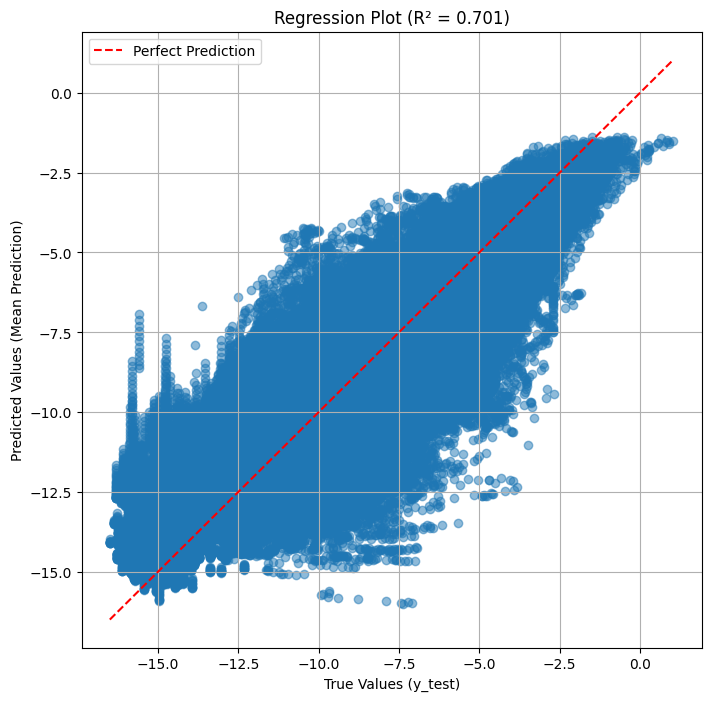

In [91]:
from sklearn.metrics import r2_score

# Mean predictions
mean_preds = mean_prediction.numpy()

# Compute R^2 (coefficient of determination) for performance evaluation
r2 = r2_score(y_test, mean_preds)

# Create the regression plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_tensor.numpy(), mean_preds, alpha=0.5)
plt.plot([y_test_tensor.min(), y_test_tensor.max()],
         [y_test_tensor.min(), y_test_tensor.max()], 'r--', label="Perfect Prediction")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (Mean Prediction)")
plt.title(f"Regression Plot (R² = {r2:.3f})")
plt.grid(True)
plt.legend()
plt.show()

tensor([[ -9.0160,  -8.8771,  -9.1222,  -8.8946,  -9.0020,  -9.0234,  -8.8640,
          -8.6006,  -8.9091,  -8.7682,  -8.7355,  -8.6289,  -8.4978,  -8.4717,
          -8.5643,  -8.3215,  -8.4670,  -8.3682,  -8.4126,  -8.0548,  -8.0751,
          -8.0673,  -7.8141,  -8.0012,  -7.6941,  -7.5529,  -7.4912,  -7.2973,
          -7.1594,  -7.0923,  -7.1086,  -6.8513,  -6.8772,  -6.6364,  -6.3782,
          -6.3465,  -6.1923,  -5.9910,  -6.1295,  -5.6441,  -5.7564,  -5.6843,
          -5.5795,  -5.6239,  -5.2307,  -5.2487,  -5.3572,  -4.8631,  -4.9429,
          -4.8973,  -4.9290,  -4.7142,  -4.7202,  -4.7534,  -4.7237,  -4.8749,
          -4.8127,  -4.5728,  -4.7885,  -4.6588,  -4.5875,  -4.6309,  -4.8151,
          -4.8578,  -4.7936,  -4.7066,  -4.8476,  -4.7515,  -4.7380,  -4.8621,
          -5.0590,  -5.1470,  -5.2089,  -5.3584,  -5.5036,  -5.6220,  -5.5793,
          -5.6737,  -5.7719,  -5.8169,  -5.9999,  -6.1124,  -6.4304,  -6.3394,
          -6.7501,  -6.8864,  -7.0309,  -7.5038,  -7

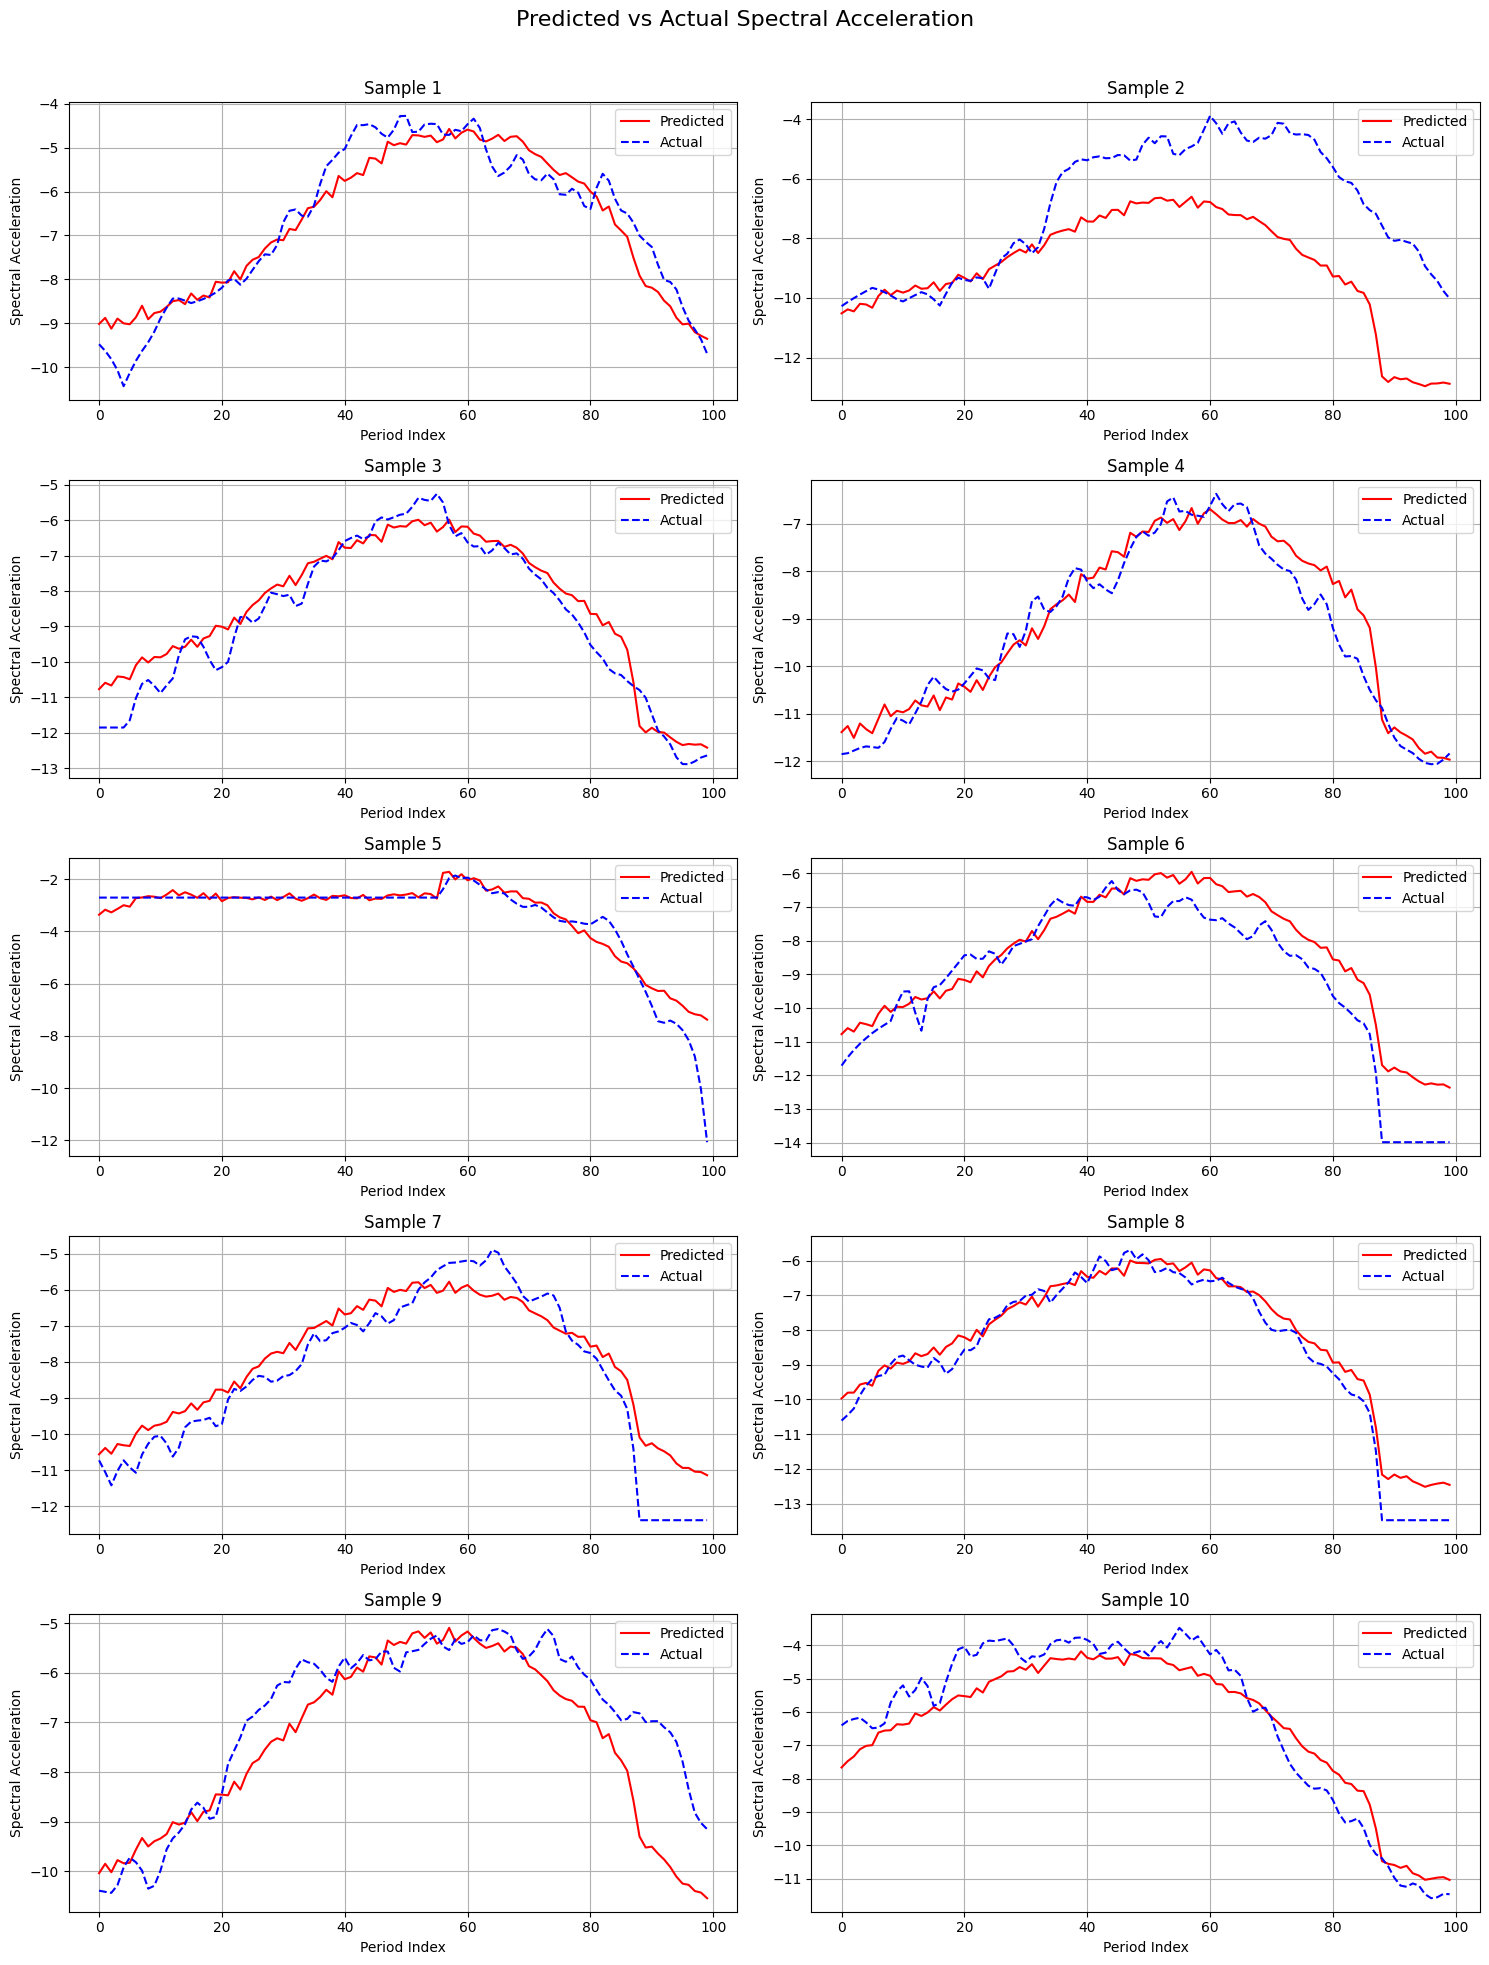

In [90]:
model.eval()

with torch.no_grad():
    pred_logsa = model(input_data_tensor[0:10])

print(pred_logsa)
fig, axes = plt.subplots(5,2, figsize=(15, 20))
fig.suptitle('Predicted vs Actual Spectral Acceleration', fontsize=16)

for i in range(10):
    row = i // 2
    col = i % 2

    periods = range(len(pred_logsa[i]))

    axes[row, col].plot(periods, pred_logsa[i].numpy(), 'r-', label='Predicted')

    axes[row, col].plot(periods, target_data_tensor[i].numpy(), 'b--', label='Actual')

    axes[row, col].set_title(f'Sample {i+1}')
    axes[row, col].set_xlabel('Period Index')
    axes[row, col].set_ylabel('Spectral Acceleration')
    axes[row, col].legend()
    axes[row, col].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for suptitle
plt.show()

In [54]:
n_samples = 1178

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

mc_preds = []

with torch.no_grad():
    for _ in range(n_samples):
        preds = model(X_test_tensor)
        mc_preds.append(preds)

mc_preds = torch.stack(mc_preds)

epistemic_uncertainty = mc_preds.var(dim=0)

mean_prediction = mc_preds.mean(dim=0)

mse = nn.MSELoss()(mean_prediction, y_test_tensor)
print(f"Test MSE: {mse.item():.4f}")
print(f"Epistemic Uncertainity: {epistemic_uncertainty.numpy()}")

Test MSE: 1.1223
Epistemic Uncertainity: [[0.08643211 0.09066717 0.08669729 ... 0.05788614 0.05581804 0.05476116]
 [0.03920921 0.04020926 0.03715603 ... 0.0532158  0.04906803 0.04667272]
 [0.06508967 0.06903444 0.06415822 ... 0.07978164 0.07992686 0.0776387 ]
 ...
 [0.08589952 0.08928166 0.08554943 ... 0.05579742 0.05299157 0.0518635 ]
 [0.07649559 0.08174137 0.07881936 ... 0.06816639 0.06494941 0.06339683]
 [0.1537094  0.16032158 0.1513655  ... 0.08011201 0.07613299 0.07676747]]


In [58]:
epistemic_uncertainty_ = 0
total_count = 0

for i in epistemic_uncertainty:
  for j in i:
    epistemic_uncertainty_ += j
    total_count += 1

epistemic_uncertainty_ / total_count

tensor(0.0519)

For time purposes, we can start training hyper-parameter tuned models till 15 epocks

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

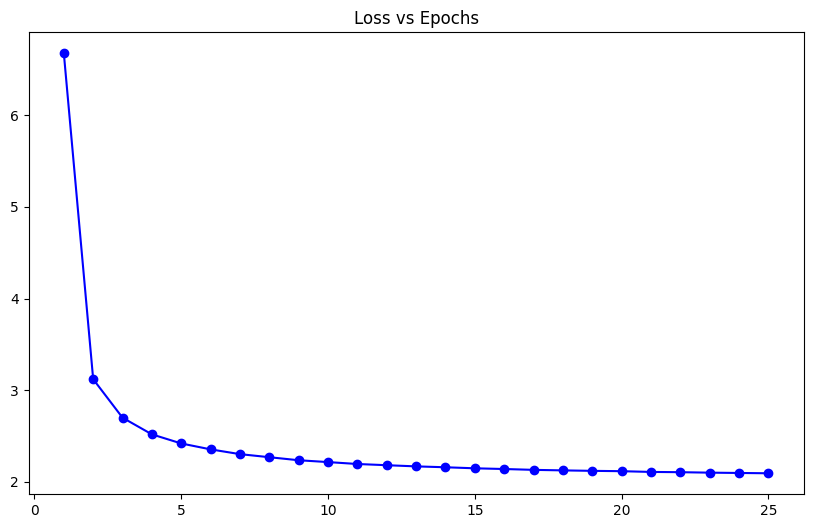

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(list(loss.keys()), list(loss.values()), marker='o', linestyle='-', color='b')
plt.title('Loss vs Epochs')
plt

In terms of hyper parameters, first adjust number of layers

In [94]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=50),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=100),
)

In [96]:
batch_size=16
lr=0.001
n_epochs=10

input_data_tensor = torch.tensor(X_train, dtype=torch.float32)
target_data_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(input_data_tensor,target_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


optimizer = optim.Adam(model.parameters(), lr=lr)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1
mse_loss = nn.MSELoss(reduction='mean')
mae_loss=nn.L1Loss(reduction='mean')

model.train()

for epoch in range(n_epochs):
    total_loss = 0
    for features,target in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        target_pred=model(features)
        loss=mse_loss(target,target_pred)+mae_loss(target,target_pred)+kl_weight*kl_loss(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:}")

Epoch 1/10: 100%|██████████| 2322/2322 [00:11<00:00, 205.21it/s]


Epoch 1, Average Loss: 2.919959204500857


Epoch 2/10: 100%|██████████| 2322/2322 [00:10<00:00, 211.41it/s]


Epoch 2, Average Loss: 2.6415609318978


Epoch 3/10: 100%|██████████| 2322/2322 [00:10<00:00, 216.33it/s]


Epoch 3, Average Loss: 2.516951823060005


Epoch 4/10: 100%|██████████| 2322/2322 [00:11<00:00, 194.23it/s]


Epoch 4, Average Loss: 2.445236716621606


Epoch 5/10: 100%|██████████| 2322/2322 [00:10<00:00, 220.37it/s]


Epoch 5, Average Loss: 2.4026717647306883


Epoch 6/10: 100%|██████████| 2322/2322 [00:11<00:00, 201.39it/s]


Epoch 6, Average Loss: 2.3717253758001697


Epoch 7/10: 100%|██████████| 2322/2322 [00:13<00:00, 178.12it/s]


Epoch 7, Average Loss: 2.355435973349365


Epoch 8/10: 100%|██████████| 2322/2322 [00:10<00:00, 214.42it/s]


Epoch 8, Average Loss: 2.3423246319287814


Epoch 9/10: 100%|██████████| 2322/2322 [00:11<00:00, 206.37it/s]


Epoch 9, Average Loss: 2.3297918771588524


Epoch 10/10: 100%|██████████| 2322/2322 [00:10<00:00, 220.03it/s]

Epoch 10, Average Loss: 2.322674015849752


In [97]:
"Average Loss = 2.322674015849752"

'Average Loss = 2.322674015849752'

In [100]:
n_samples = 1178

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

mc_preds = []

with torch.no_grad():
    for _ in range(n_samples):
        preds = model(X_test_tensor)
        mc_preds.append(preds)

mc_preds = torch.stack(mc_preds)

epistemic_uncertainty = mc_preds.var(dim=0)

mean_prediction = mc_preds.mean(dim=0)

mse = nn.MSELoss()(mean_prediction, y_test_tensor)
print(f"Test MSE: {mse.item():.4f}")
print(f"Epistemic Uncertainity: {epistemic_uncertainty.numpy()}")

Test MSE: 1.1635
Epistemic Uncertainity: [[0.0387231  0.04036689 0.04106287 ... 0.05021701 0.05179016 0.047935  ]
 [0.0385794  0.03847959 0.04086198 ... 0.04570326 0.04794273 0.04492528]
 [0.06496295 0.06446172 0.06348611 ... 0.09227484 0.08540631 0.0818766 ]
 ...
 [0.04011319 0.04178112 0.04277502 ... 0.0515101  0.05349112 0.0493733 ]
 [0.03753407 0.03873093 0.0391726  ... 0.0478096  0.04845158 0.04612891]
 [0.04672043 0.04821183 0.04756074 ... 0.05878602 0.05884704 0.05863195]]


In [101]:
from sklearn.metrics import r2_score

mean_preds = mean_prediction.numpy()

r2 = r2_score(y_test, mean_preds)
r2

0.6898166159073543

Now, using two layers

In [102]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=30),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=30, out_features=70),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=70, out_features=100),
)

In [103]:
batch_size=16
lr=0.001
n_epochs=10

input_data_tensor = torch.tensor(X_train, dtype=torch.float32)
target_data_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(input_data_tensor,target_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


optimizer = optim.Adam(model.parameters(), lr=lr)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1
mse_loss = nn.MSELoss(reduction='mean')
mae_loss=nn.L1Loss(reduction='mean')

model.train()

for epoch in range(n_epochs):
    total_loss = 0
    for features,target in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        target_pred=model(features)
        loss=mse_loss(target,target_pred)+mae_loss(target,target_pred)+kl_weight*kl_loss(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:}")

Epoch 1/10: 100%|██████████| 2322/2322 [00:16<00:00, 144.02it/s]


Epoch 1, Average Loss: 6.382291729238709


Epoch 2/10: 100%|██████████| 2322/2322 [00:17<00:00, 129.93it/s]


Epoch 2, Average Loss: 2.9473691047726778


Epoch 3/10: 100%|██████████| 2322/2322 [00:18<00:00, 126.21it/s]


Epoch 3, Average Loss: 2.6797607184791237


Epoch 4/10: 100%|██████████| 2322/2322 [00:15<00:00, 150.78it/s]


Epoch 4, Average Loss: 2.5235785700759426


Epoch 5/10: 100%|██████████| 2322/2322 [00:15<00:00, 147.21it/s]


Epoch 5, Average Loss: 2.412546053515951


Epoch 6/10: 100%|██████████| 2322/2322 [00:16<00:00, 143.73it/s]


Epoch 6, Average Loss: 2.3488099893344874


Epoch 7/10: 100%|██████████| 2322/2322 [00:15<00:00, 151.86it/s]


Epoch 7, Average Loss: 2.2980251642879383


Epoch 8/10: 100%|██████████| 2322/2322 [00:15<00:00, 146.77it/s]


Epoch 8, Average Loss: 2.262705324796846


Epoch 9/10: 100%|██████████| 2322/2322 [00:15<00:00, 154.23it/s]


Epoch 9, Average Loss: 2.23337273819502


Epoch 10/10: 100%|██████████| 2322/2322 [00:13<00:00, 166.41it/s]

Epoch 10, Average Loss: 2.2043571992746003


In [104]:
n_samples = 1178

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

mc_preds = []

with torch.no_grad():
    for _ in range(n_samples):
        preds = model(X_test_tensor)
        mc_preds.append(preds)

mc_preds = torch.stack(mc_preds)

epistemic_uncertainty = mc_preds.var(dim=0)

mean_prediction = mc_preds.mean(dim=0)

mse = nn.MSELoss()(mean_prediction, y_test_tensor)
print(f"Test MSE: {mse.item():.4f}")
print(f"Epistemic Uncertainity: {epistemic_uncertainty.numpy()}")

Test MSE: 1.1588
Epistemic Uncertainity: [[0.06673044 0.07080762 0.06910449 ... 0.07912203 0.07899091 0.08639818]
 [0.05671968 0.06158355 0.05971797 ... 0.0679848  0.06907655 0.0721083 ]
 [0.11456989 0.11768226 0.11449932 ... 0.13720143 0.12814382 0.14427617]
 ...
 [0.0685444  0.07278622 0.07038533 ... 0.08128135 0.081411   0.08803897]
 [0.06134086 0.06386265 0.06032822 ... 0.07393263 0.07180402 0.07910024]
 [0.07209742 0.07650168 0.07300759 ... 0.08754971 0.08674102 0.09396122]]


In [105]:
from sklearn.metrics import r2_score

mean_preds = mean_prediction.numpy()

r2 = r2_score(y_test, mean_preds)
r2

0.6912712455021119

In [106]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=40),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=40, out_features=50),
    nn.LeakyReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=80),
    nn.LeakyReLU(),

    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=80, out_features=100),
)

In [107]:
batch_size=16
lr=0.001
n_epochs=25

input_data_tensor = torch.tensor(X_train, dtype=torch.float32)
target_data_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(input_data_tensor,target_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


optimizer = optim.Adam(model.parameters(), lr=lr)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1
mse_loss = nn.MSELoss(reduction='mean')
mae_loss=nn.L1Loss(reduction='mean')

model.train()

for epoch in range(n_epochs):
    total_loss = 0
    for features,target in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        target_pred=model(features)
        loss=mse_loss(target,target_pred)+mae_loss(target,target_pred)+kl_weight*kl_loss(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:}")

Epoch 1/25: 100%|██████████| 2322/2322 [00:21<00:00, 107.42it/s]


Epoch 1, Average Loss: 6.421769136298226


Epoch 2/25: 100%|██████████| 2322/2322 [00:19<00:00, 118.57it/s]


Epoch 2, Average Loss: 3.037321590535298


Epoch 3/25: 100%|██████████| 2322/2322 [00:20<00:00, 115.22it/s]


Epoch 3, Average Loss: 2.6483768412103745


Epoch 4/25: 100%|██████████| 2322/2322 [00:20<00:00, 114.40it/s]


Epoch 4, Average Loss: 2.4864435762706036


Epoch 5/25: 100%|██████████| 2322/2322 [00:22<00:00, 103.52it/s]


Epoch 5, Average Loss: 2.397382026905648


Epoch 6/25: 100%|██████████| 2322/2322 [00:20<00:00, 111.99it/s]


Epoch 6, Average Loss: 2.327435149754254


Epoch 7/25: 100%|██████████| 2322/2322 [00:18<00:00, 123.68it/s]


Epoch 7, Average Loss: 2.2768419585178683


Epoch 8/25: 100%|██████████| 2322/2322 [00:20<00:00, 113.18it/s]


Epoch 8, Average Loss: 2.2463854586739256


Epoch 9/25: 100%|██████████| 2322/2322 [00:19<00:00, 121.48it/s]


Epoch 9, Average Loss: 2.21957788674817


Epoch 10/25: 100%|██████████| 2322/2322 [00:20<00:00, 114.72it/s]


Epoch 10, Average Loss: 2.1959589371693533


Epoch 11/25: 100%|██████████| 2322/2322 [00:20<00:00, 115.49it/s]


Epoch 11, Average Loss: 2.175162431343581


Epoch 12/25: 100%|██████████| 2322/2322 [00:20<00:00, 114.97it/s]


Epoch 12, Average Loss: 2.159970435985299


Epoch 13/25: 100%|██████████| 2322/2322 [00:18<00:00, 127.46it/s]


Epoch 13, Average Loss: 2.148921803037839


Epoch 14/25: 100%|██████████| 2322/2322 [00:20<00:00, 113.45it/s]


Epoch 14, Average Loss: 2.134042460840391


Epoch 15/25: 100%|██████████| 2322/2322 [00:19<00:00, 117.64it/s]


Epoch 15, Average Loss: 2.1258476763116603


Epoch 16/25: 100%|██████████| 2322/2322 [00:19<00:00, 117.42it/s]


Epoch 16, Average Loss: 2.118169584836968


Epoch 17/25: 100%|██████████| 2322/2322 [00:19<00:00, 120.39it/s]


Epoch 17, Average Loss: 2.109005270283557


Epoch 18/25: 100%|██████████| 2322/2322 [00:20<00:00, 115.76it/s]


Epoch 18, Average Loss: 2.100136022183733


Epoch 19/25: 100%|██████████| 2322/2322 [00:19<00:00, 121.24it/s]


Epoch 19, Average Loss: 2.097607127199083


Epoch 20/25: 100%|██████████| 2322/2322 [00:19<00:00, 116.27it/s]


Epoch 20, Average Loss: 2.0866807075433953


Epoch 21/25: 100%|██████████| 2322/2322 [00:19<00:00, 119.35it/s]


Epoch 21, Average Loss: 2.0858378209603643


Epoch 22/25: 100%|██████████| 2322/2322 [00:22<00:00, 103.29it/s]


Epoch 22, Average Loss: 2.081885172979879


Epoch 23/25: 100%|██████████| 2322/2322 [00:21<00:00, 107.68it/s]


Epoch 23, Average Loss: 2.076405025216447


Epoch 24/25: 100%|██████████| 2322/2322 [00:19<00:00, 118.80it/s]


Epoch 24, Average Loss: 2.07392891859002


Epoch 25/25: 100%|██████████| 2322/2322 [00:21<00:00, 109.89it/s]

Epoch 25, Average Loss: 2.0702315463165495


In [108]:
n_samples = 1178

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

mc_preds = []

with torch.no_grad():
    for _ in range(n_samples):
        preds = model(X_test_tensor)
        mc_preds.append(preds)

mc_preds = torch.stack(mc_preds)

epistemic_uncertainty = mc_preds.var(dim=0)

mean_prediction = mc_preds.mean(dim=0)

mse = nn.MSELoss()(mean_prediction, y_test_tensor)
print(f"Test MSE: {mse.item():.4f}")
print(f"Epistemic Uncertainity: {epistemic_uncertainty.numpy()}")

Test MSE: 1.1186
Epistemic Uncertainity: [[0.01773086 0.02037156 0.01840357 ... 0.02168278 0.02139401 0.02295247]
 [0.01524905 0.01635146 0.01538865 ... 0.01777219 0.01929392 0.01972104]
 [0.03425929 0.03612836 0.03297997 ... 0.03802812 0.03614763 0.04035794]
 ...
 [0.01830468 0.02083916 0.01902421 ... 0.02168108 0.02179267 0.02328892]
 [0.01613332 0.01669029 0.01542762 ... 0.01933113 0.01970622 0.02133741]
 [0.01643378 0.01763295 0.01648177 ... 0.02042678 0.02020663 0.02189679]]


In [109]:
from sklearn.metrics import r2_score

mean_preds = mean_prediction.numpy()

r2 = r2_score(y_test, mean_preds)
r2

0.7021450486958228

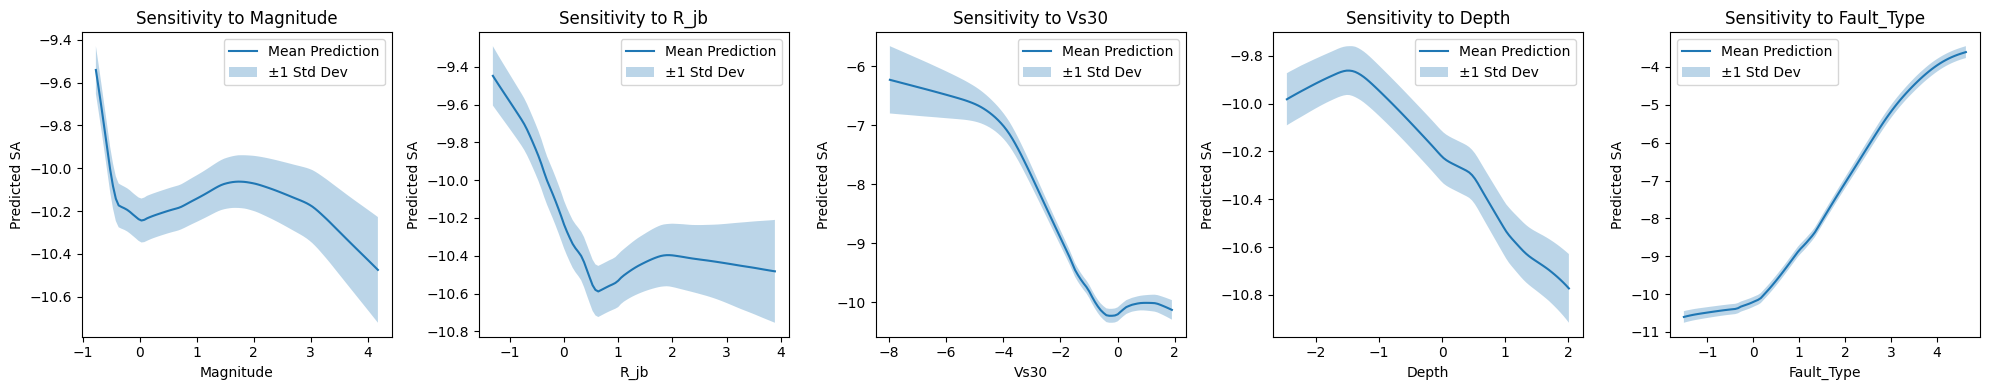

In [113]:
input_names = ['Magnitude', 'R_jb', 'Vs30', 'Depth', 'Fault_Type']

# Choose number of sweep points
n_points = 100

# Base input = mean of test set (shape: [1, 5])
base_input = torch.tensor(np.mean(X_test, axis=0), dtype=torch.float32).unsqueeze(0)

# Set up subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    # Sweep current variable from min to max
    sweep_vals = torch.linspace(min(X_test[:, i]), max(X_test[:, i]), n_points)
    inputs = base_input.repeat(n_points, 1)
    inputs[:, i] = sweep_vals

    # Run through BNN multiple times for uncertainty
    with torch.no_grad():
        preds = []
        for _ in range(100):  # 100 samples for MC dropout / Bayesian inference
            preds.append(model(inputs))
        preds = torch.stack(preds)
        mean_preds = preds.mean(dim=0)  # [n_points, 100]
        std_preds = preds.std(dim=0)

    # Plot mean ± std of one output frequency (e.g., index 0)
    freq_idx = 0
    axes[i].plot(sweep_vals.numpy(), mean_preds[:, freq_idx].numpy(), label='Mean Prediction')
    axes[i].fill_between(sweep_vals.numpy(),
                         (mean_preds[:, freq_idx] - std_preds[:, freq_idx]).numpy(),
                         (mean_preds[:, freq_idx] + std_preds[:, freq_idx]).numpy(),
                         alpha=0.3, label='±1 Std Dev')
    axes[i].set_title(f'Sensitivity to {input_names[i]}')
    axes[i].set_xlabel(input_names[i])
    axes[i].set_ylabel('Predicted SA')
    axes[i].legend()

plt.tight_layout()
plt.show()